In [1]:
import pandas as pd

In [2]:
# get compensation data 
    #referecnce for loop

# get PXlast for 503 spx
PX_last_data = pd.read_csv("../../data/503PXlast.csv")
PX_last_data["DATES"] =  pd.to_datetime(PX_last_data["DATES"])

#get missing data for PX_last
    #PX_last_missing = PX_last_data.columns[PX_last_data.isna().any()].tolist()
    #union_list = set(PX_last_missing).union(union_list)
    #union_list = list(union_list)
    #PX_last_data = PX_last_data.drop(union_list,axis=1) # drop missing data for now
PX_last_data_melt = pd.melt(PX_last_data,id_vars=['DATES'], var_name='symbol',value_name="PX_last")


# get sector categories  GICS data
GICS_data = pd.read_csv("../../data/503_GICSData.csv")
GICS_data.rename(columns={"Symbol":"symbol"},inplace=True)

# get marketcap for 503 spx
MarketCap_data = pd.read_csv("../../data/CUR_MKT_CAP_SPX.csv") 
MarketCap_data_melt = pd.melt(MarketCap_data,id_vars=['Dates'], var_name='symbol',value_name="MarketCap")


# compute weights for each sector using iloc & groupby 
merged_df = GICS_data
#merged_df = pd.merge(merged_df,GICS_data,left_on="symbol",right_on="Symbol",how="left" )
merged_df = pd.merge(merged_df,PX_last_data_melt,left_on="symbol",right_on="symbol",how="left" )
merged_df.rename(columns={'DATES': 'Date'},inplace=True)
MarketCap_data_melt.rename(columns={'Dates': 'Date'},inplace=True)
MarketCap_data_melt["Date"] =  pd.to_datetime(MarketCap_data_melt["Date"])
merged_df["Date"] =  pd.to_datetime(merged_df["Date"])
merged_df = pd.merge(merged_df,MarketCap_data_melt,on=["Date", "symbol"],how="outer" )
merged_df["year"] = merged_df["Date"].dt.year
#compute weights for each sector by date
merged_df["marketcap_weight"] = merged_df.groupby(["Date", "gics_sector_name"])["MarketCap"].apply(lambda x: x / x.sum())
merged_df.dropna(inplace=True)


In [ ]:
#read in sector ETFs
PX_last_ETF = pd.read_csv("../../data/pxlast_sector_ETF.csv")
CUR_MKT_CAP_ETF = pd.read_csv("../../data/CUR_MKT_CAP_Sector_ETF.csv")
CUR_MKT_CAP_ETF.fillna(0, inplace=True)
PX_last_ETF=pd.melt(PX_last_ETF,id_vars=['Dates'], var_name='symbol',value_name="PX_last")
CUR_MKT_CAP_ETF=pd.melt(CUR_MKT_CAP_ETF,id_vars=['Dates'], var_name='symbol',value_name="CUR_MKT_CAP")
Data_ETF=pd.merge(PX_last_ETF, CUR_MKT_CAP_ETF, on=["Dates", "symbol"], how="outer")
Data_ETF["Dates"] = pd.to_datetime(Data_ETF["Dates"])
Data_ETF.rename(columns={"Dates":"Date"},inplace=True)
Data_ETF.dropna(inplace=True)

In [4]:
# read execuative compensation data
compensation_data = pd.read_csv("../data_reformat/merged_data.csv")
compensation_data["Date"] = pd.to_datetime(compensation_data["Date"])
compensation_data["year"] =compensation_data["Date"].dt.year
#merged compensation with sector 
merged_df = pd.merge(merged_df,compensation_data,on=["symbol", "year"],how="left" )

In [5]:
# add columns to data 
merged_df.loc[:,"equity_Compensation_CEO"] = merged_df['TOT_STK_AWD_GIVEN_TO_CEO_EQUIV']+merged_df["TOT_OPT_AWD_GIVEN_TO_CEO_EQUIV"]   # Equity compensation   = Total stock awards + Total option awards
merged_df.loc[:,"cash_incentive_CEO"] = merged_df['TOT_BONUSES_PAID_TO_CEO_EQUIV']+merged_df['TOT_N_EQT_INCENT_GVN_TO_CEO_EQ']         # Cash incentive        = Total bonuses paid + Total equity incentive given
merged_df.loc[:,"Variable_Pay_CEO"] = merged_df["cash_incentive_CEO"]+merged_df["equity_Compensation_CEO"]                             # Variable Pay          = Cash incentive + Equity incentive
merged_df.loc[:,"cash_incentive_CEO_percent"] = merged_df["cash_incentive_CEO"]/merged_df["Variable_Pay_CEO"]                          # Cash incentive ratio  = Cash incentive / (Cash incentive + Equity incentive)


In [8]:
#compute the average sector compensation (change Date_x  to date)
ETF_cash_incentive_CEO_percent = merged_df.groupby(["Date_x", "gics_sector_name"]).apply(lambda g: (g["marketcap_weight"] * g["cash_incentive_CEO_percent"]).sum()).reset_index(name="avg_h_incentive_CEO_percent")


In [ ]:
sector_to_symbol={
  "Communication Services": "XLC US Equity",
  "Consumer Discretionary": "XLY US Equity",
  "Consumer Staples": "XLP US Equity",
  "Energy": "XLE US Equity",
  "Financials": "XLF US Equity",
  "Health Care": "XLV US Equity",
  "Industrials": "XLI US Equity",
  "Materials": "XLB US Equity",
  "Real Estate": "XLRE US Equity",
  "Information Technology": "XLK US Equity",
  "Utilities": "XLU US Equity"
}

ETF_cash_incentive_CEO_percent["symbol"] = ETF_cash_incentive_CEO_percent["gics_sector_name"].map(sector_to_symbol)
ETF_cash_incentive_CEO_percent.rename(columns={"Date_x":"Date"},inplace=True)
Data_ETF = pd.merge(Data_ETF,ETF_cash_incentive_CEO_percent,on=["Date","symbol"],how="inner")

In [49]:
Data_ETF.head()

,Date,symbol,PX_last,CUR_MKT_CAP,gics_sector_name,avg_h_incentive_CEO_percent
0,2018-06-22,XLC US Equity,50.49,25.245,Communication Services,0.060263
1,2018-06-29,XLC US Equity,49.53,173.355,Communication Services,0.061551
2,2018-07-06,XLC US Equity,50.77,205.619,Communication Services,0.061180
3,2018-07-13,XLC US Equity,51.69,276.541,Communication Services,0.060127
4,2018-07-20,XLC US Equity,50.87,284.872,Communication Services,0.059442


(5521,)

In [65]:
from matplotlib.dates import date2num
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
import numpy as np

In [ ]:
def plot_returns(symbol):
    company_df = Data_ETF[Data_ETF['symbol'] == symbol].copy()
    #
    # Get weeks count
    dates = company_df['Date'].iloc[1:].to_numpy()
    dates = date2num(dates)
    
    # Get Numpy array of weekly returns
    weekly_returns = company_df['PX_last']
    

    # Get Numpy array of CEO cash incentive percentages
    cash_incentive = company_df['avg_h_incentive_CEO_percent'].iloc[1:].to_numpy()

    # Get Numpy array of date of last CEO change (exclude for now) 
    #exec_changes = company_df['COMP_LKD_LAST_CEO_&_EQUIV_CHG_DT'].iloc[1:].to_numpy()
    #exec_changes = np.unique(exec_changes)

    share_price = company_df['PX_last'].iloc[1:].to_numpy()
    
    
    # Plot setup
    plt.figure(figsize=(20, 8))  # Set figure size for better visualization
    
    # Normalize the cash incentive percent to use as a gradient
    norm = Normalize(vmin=0, vmax=1)  # Dynamically adjust normalization
    cmap = 'gist_rainbow'  # Choose the colormap for line coloring
    
    # # 1. Calculate the dates when the cash incentive ratio changes significantly (more than the threshold)
    # threshold = 0.01  # 1% threshold to detect significant changes in incentive
    # diff = np.diff(cash_incentive)  # Calculate the difference between consecutive values
    # relative_change = np.abs(diff) / cash_incentive[:-1]  # Calculate the relative change (percent change)
    # change_indices = np.where(relative_change > threshold)[0] + 1  # Get the indices where change exceeds the threshold
    # change_dates = dates[change_indices]  # Extract the corresponding dates for these changes
    
    # 2. Ensure the cash_incentive array matches the length of dates for plotting
    if len(cash_incentive) == len(dates):
        cash_incentive = cash_incentive[:-1]  # Adjust the length of cash_incentive if needed
    
    # 3. Create a list of line segments for plotting the weekly returns
    segments = [
        [(dates[i - 1], share_price[i - 1]), (dates[i], share_price[i])]
        for i in range(1, len(dates))
    ]
    
    # 4. Create a LineCollection for the line segments, using the cash_incentive array for coloring
    line_segments = LineCollection(
        segments, cmap=cmap, norm=norm, array=cash_incentive, linewidth=2
    )
    
    # 5. Plot the line segments on the graph
    ax = plt.gca()  # Get the current axis to add elements
    ax.add_collection(line_segments)  # Add the line segments to the plot
    ax.autoscale()  # Rescale axes to ensure the line collection fits
    
    # # 6. Plot vertical lines for the significant cash incentive changes
    # for change_date in change_dates:
    #     ax.axvline(change_date, color='green', linestyle='--', linewidth=1, label='Compensation Ratio Change')
    
    # 7. Plot vertical lines for the executive change dates (Exclude for now)
    # for change_date in exec_changes:
    #     # if date2num(change_date) < date2num(min(company_df['Dates'])):
    #     #     continue
    #     ax.axvline(change_date, color='purple', linestyle='-', linewidth=2, label='CEO Change')
    
    # 8. Add a color bar to show the scale of cash incentive percent
    cbar = plt.colorbar(line_segments, shrink=0.65)
    cbar.set_label("Cash Incentive Percent (%)")
    tick_values = np.linspace(0.0, 1.0, 11)  # Generate 11 evenly spaced values from 0.0 to 1.0
    cbar.set_ticks(tick_values)  # Set these as the ticks for the color bar
    cbar.set_ticklabels([f"{tick:.1f}" for tick in tick_values])  # Format tick labels to one decimal place
    # Adjust the label position to the left
    cbar.ax.yaxis.set_label_position('left')  # Set the label position to the left
    cbar.ax.yaxis.set_ticks_position('right')  # Move the ticks to the left side
    
    # 9. Format the x-axis to show yearcash_incentive = company_df['cash_incentive_CEO_percent'].iloc[1:].to_numpy()s and automatically adjust date ticks
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display years on the x-axis
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically set the date intervals
    
    # 10. Customize labels and titles
    plt.xlabel("Dates")  # Set the x-axis label
    plt.ylabel("Shareprice (USD)")  # Set the y-axis label
    title_str = symbol + ' shareprice over time'
    plt.title(title_str)  # Set the title of the plot
    
    # 11. Adjust x-tick labels and y-ticks
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    tick_step = 20  # Adjust for finer control over steps on the y-axis
    y_ticks = np.arange(np.floor(min(share_price) / tick_step) * tick_step, 
                        np.ceil(max(share_price) / tick_step) * tick_step + tick_step, 
                        tick_step)
    plt.yticks(y_ticks)
    
    # 12. Add grid for better readability
    plt.grid()
    
    # 13. Add legend to the plot
    # Remove duplicate entries from the legend
    handles, labels = ax.get_legend_handles_labels()
    # Use a dictionary to eliminate duplicates (labels are keys)
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys(), loc='upper left', bbox_to_anchor=(1, 1), title='Legend')
    
    
    # 14. Adjust layout to ensure everything fits
    plt.tight_layout()
    
    # 15. Show the plot
    #plt.show()
    
    path = 'graphs/' + symbol + '.png'
    plt.savefig(path)

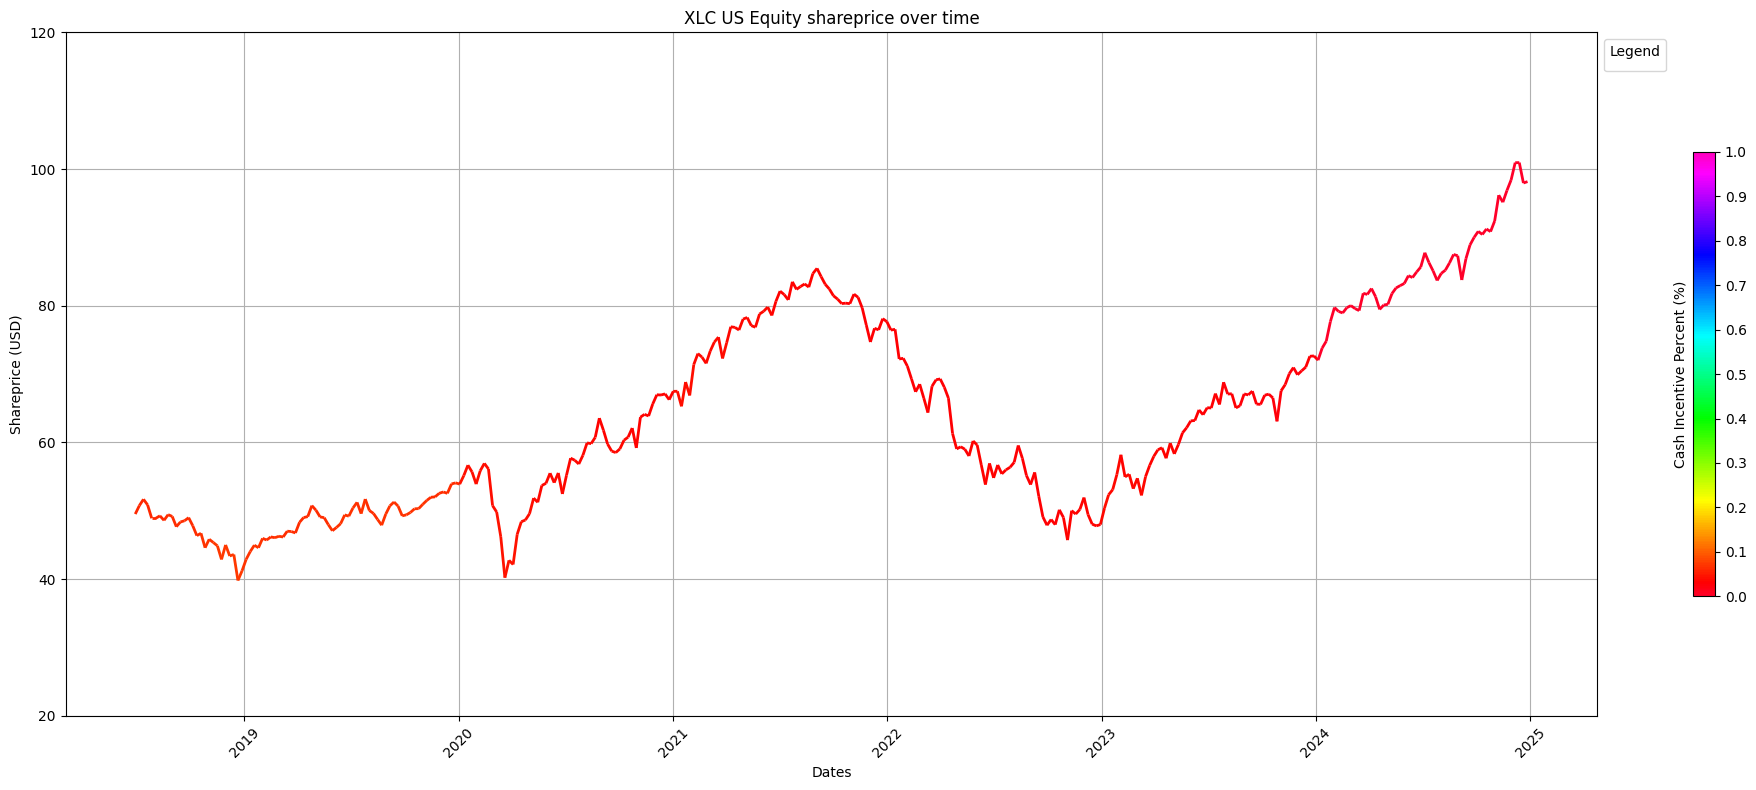

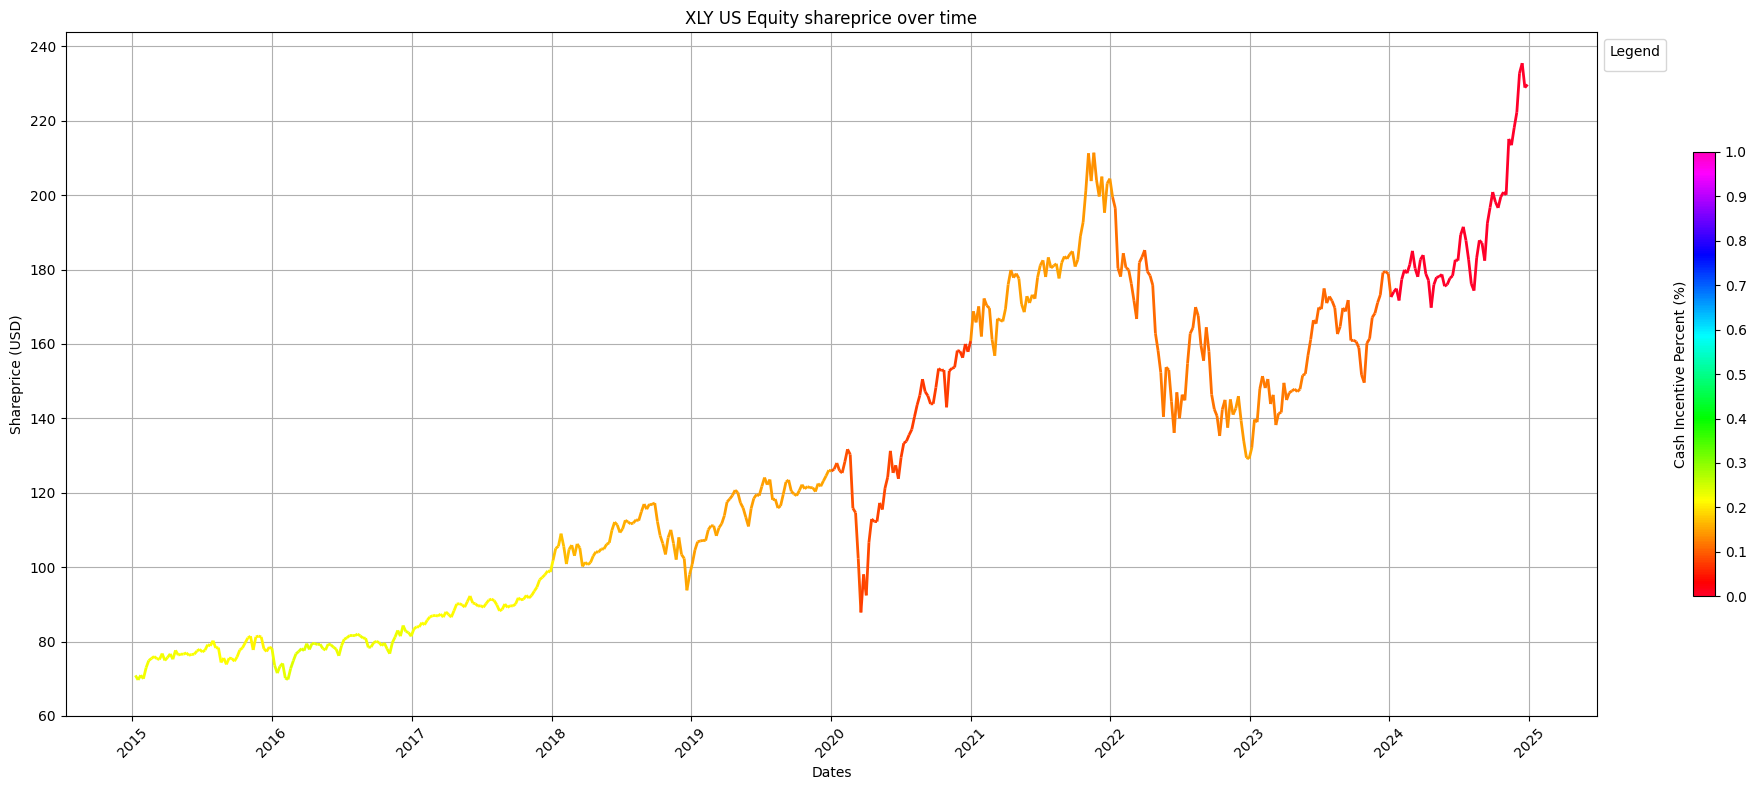

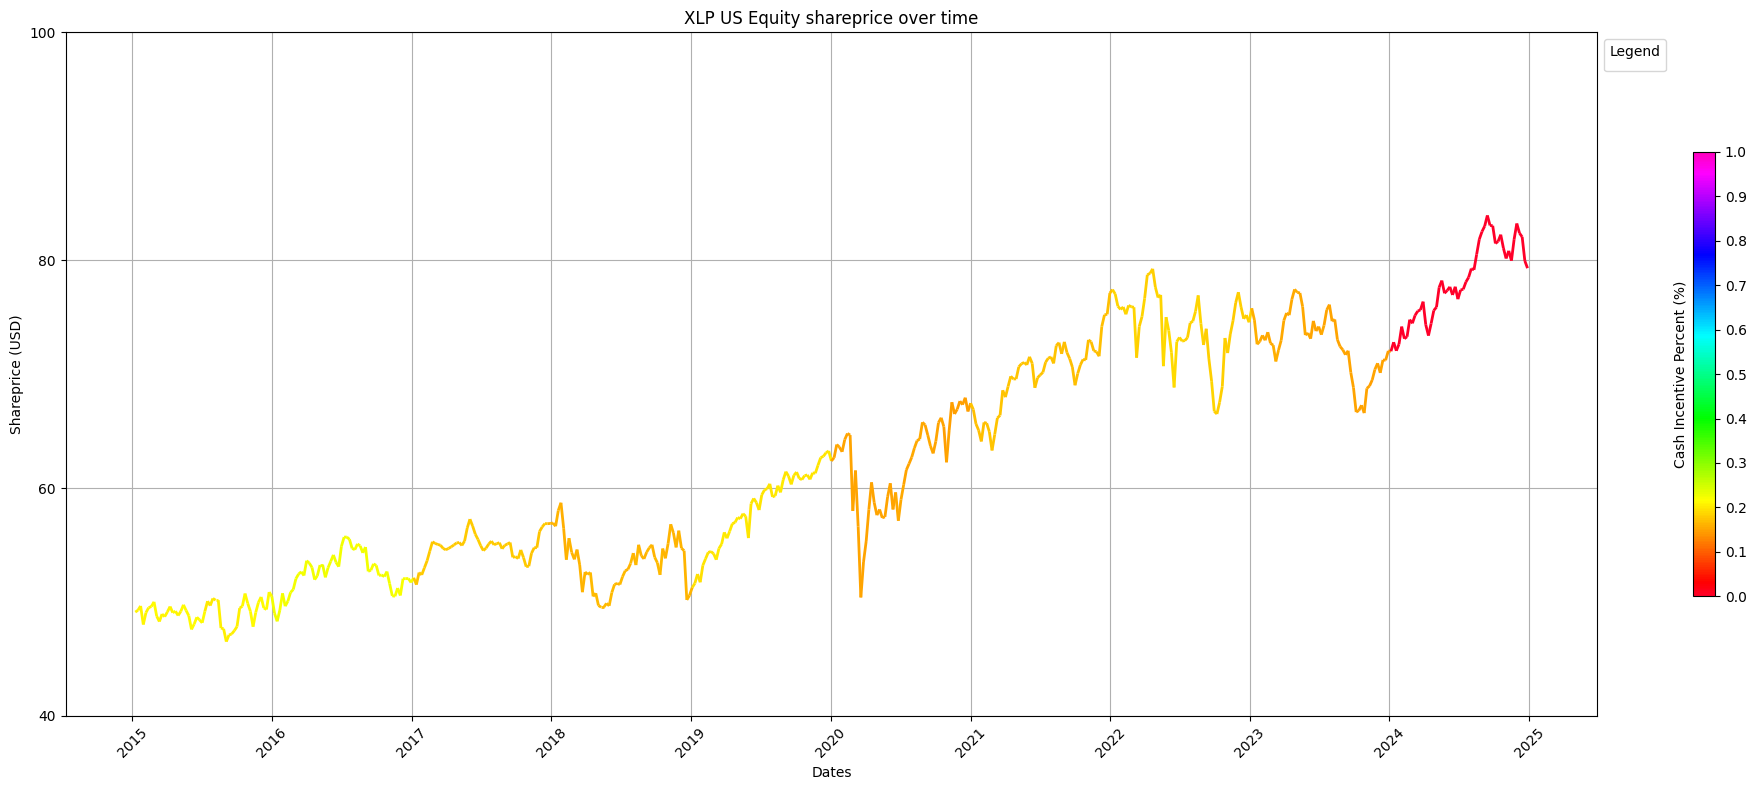

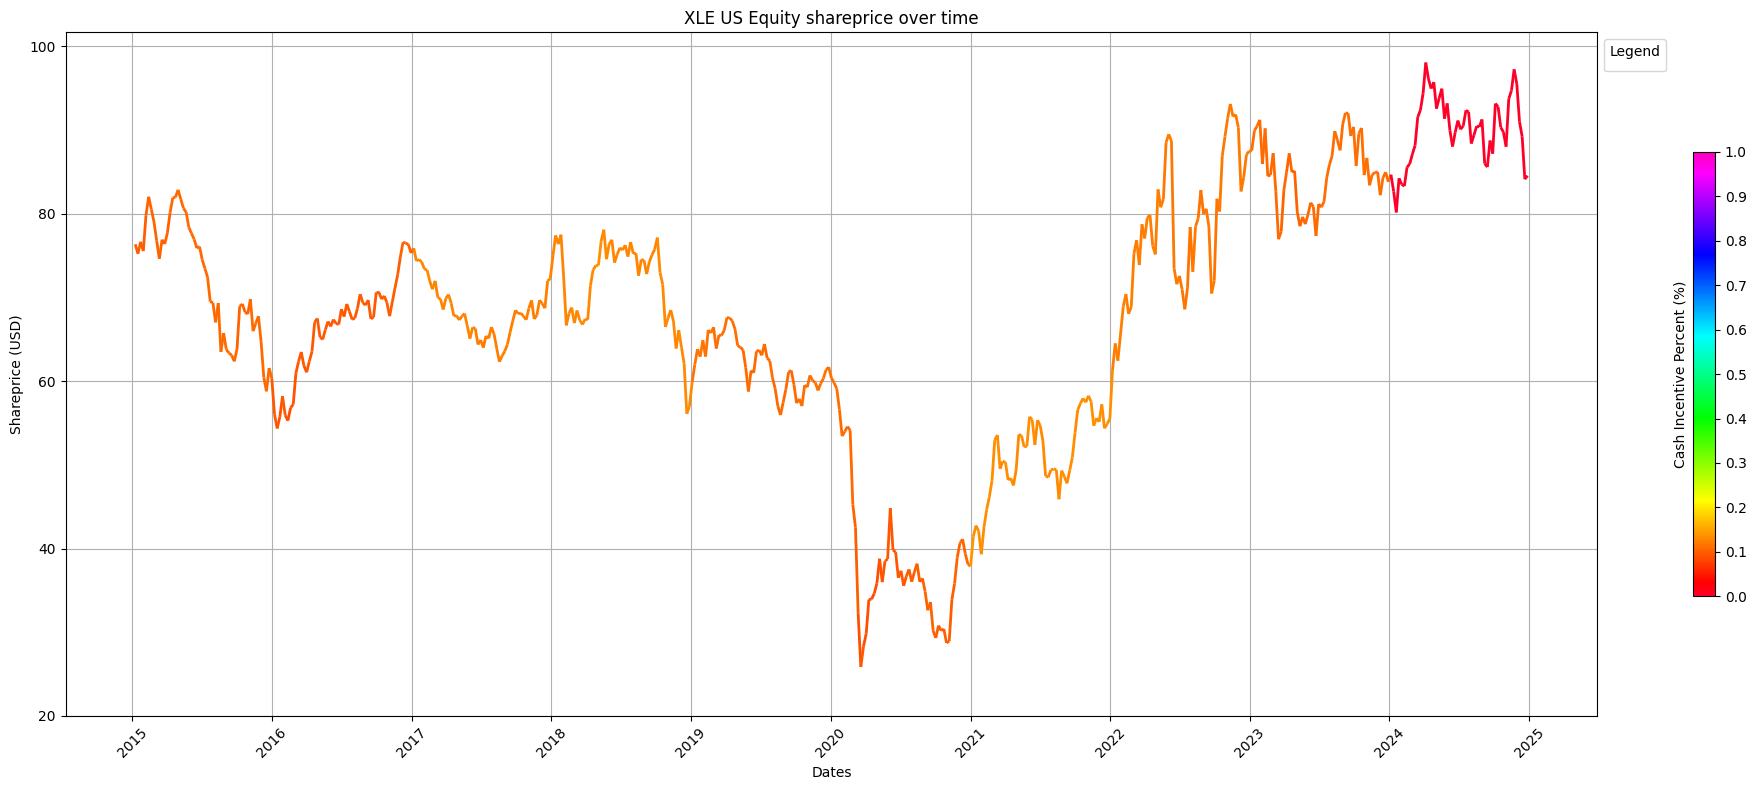

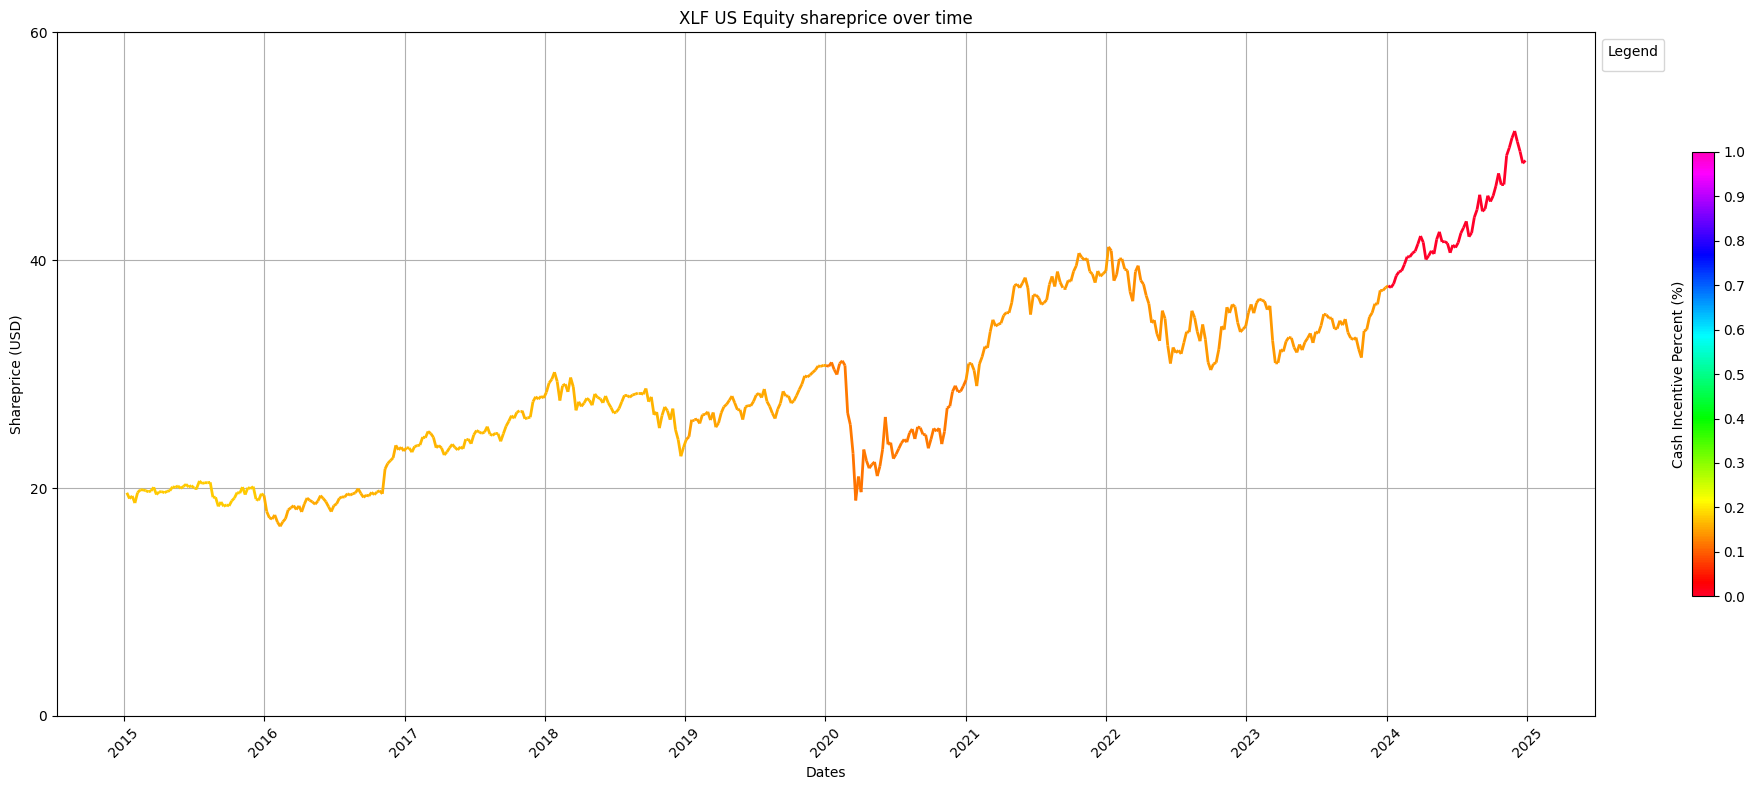

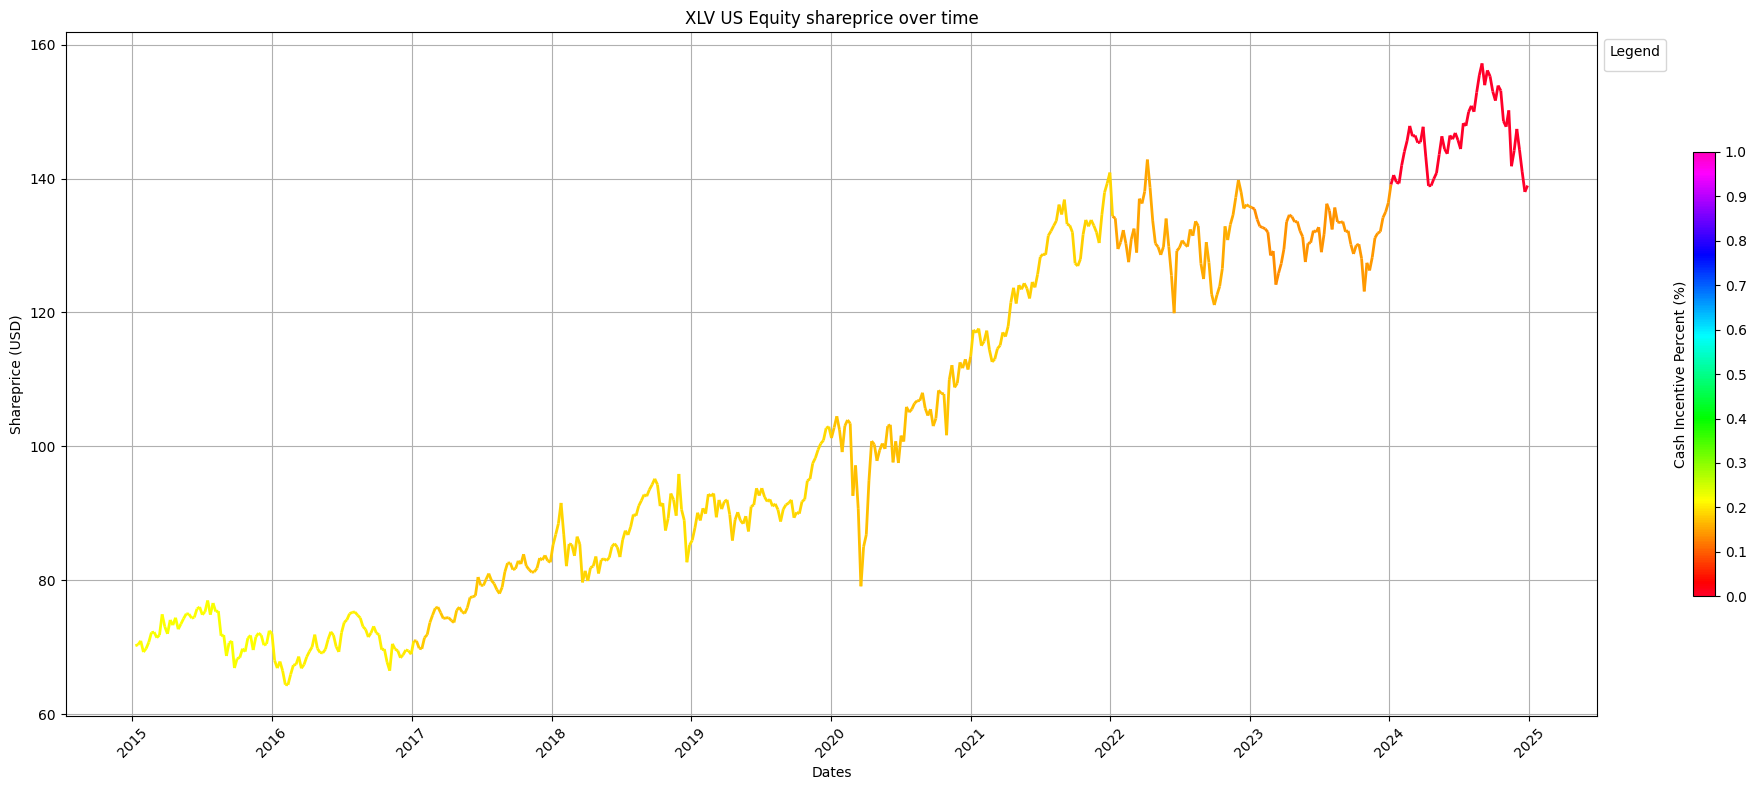

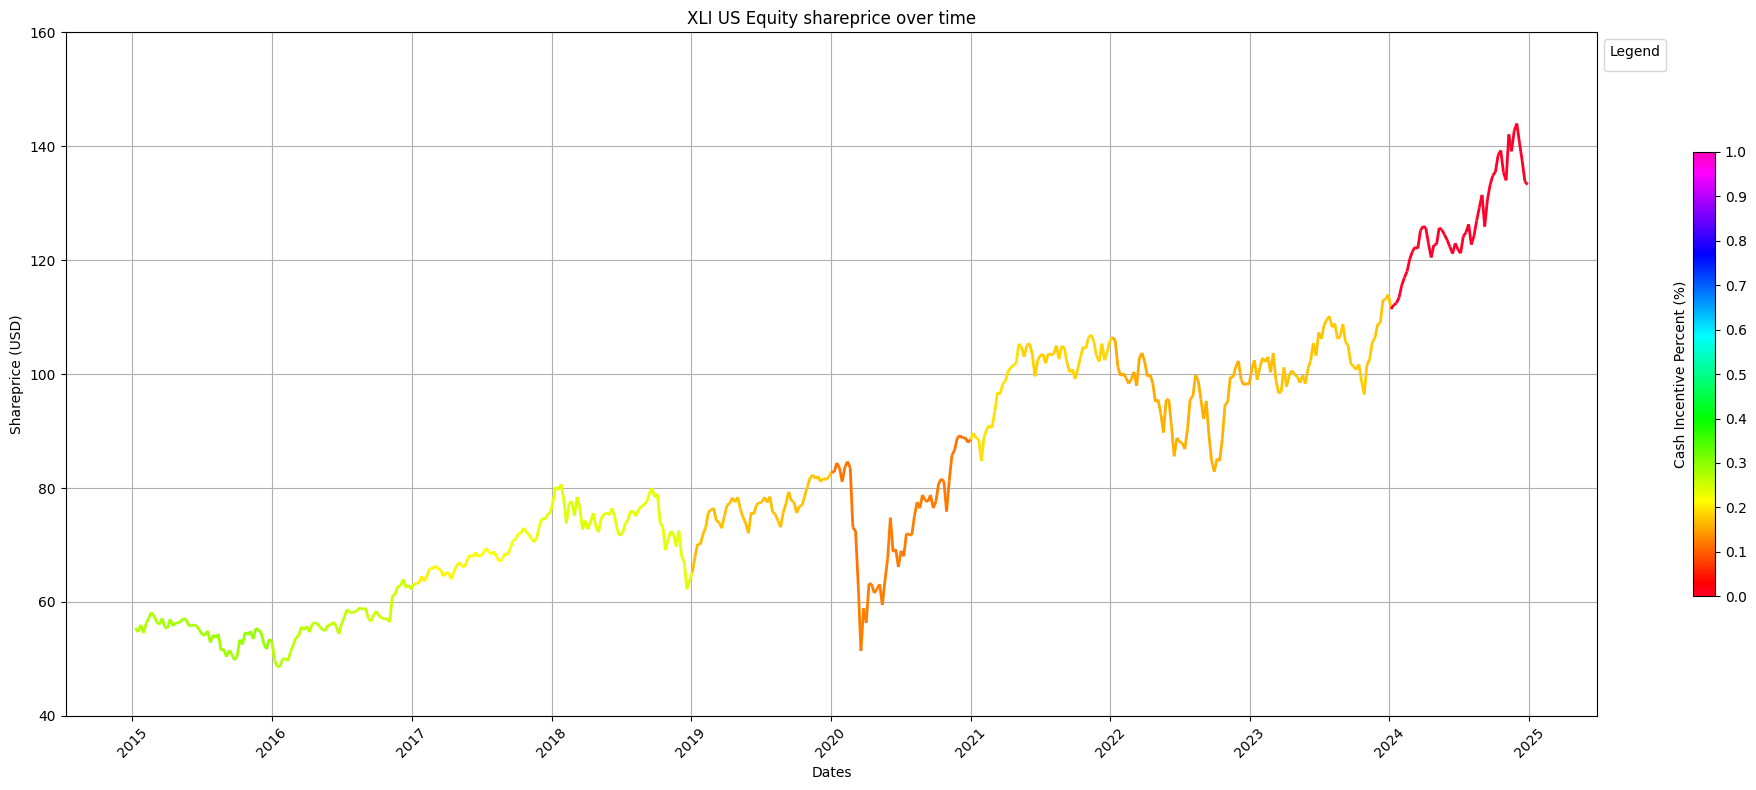

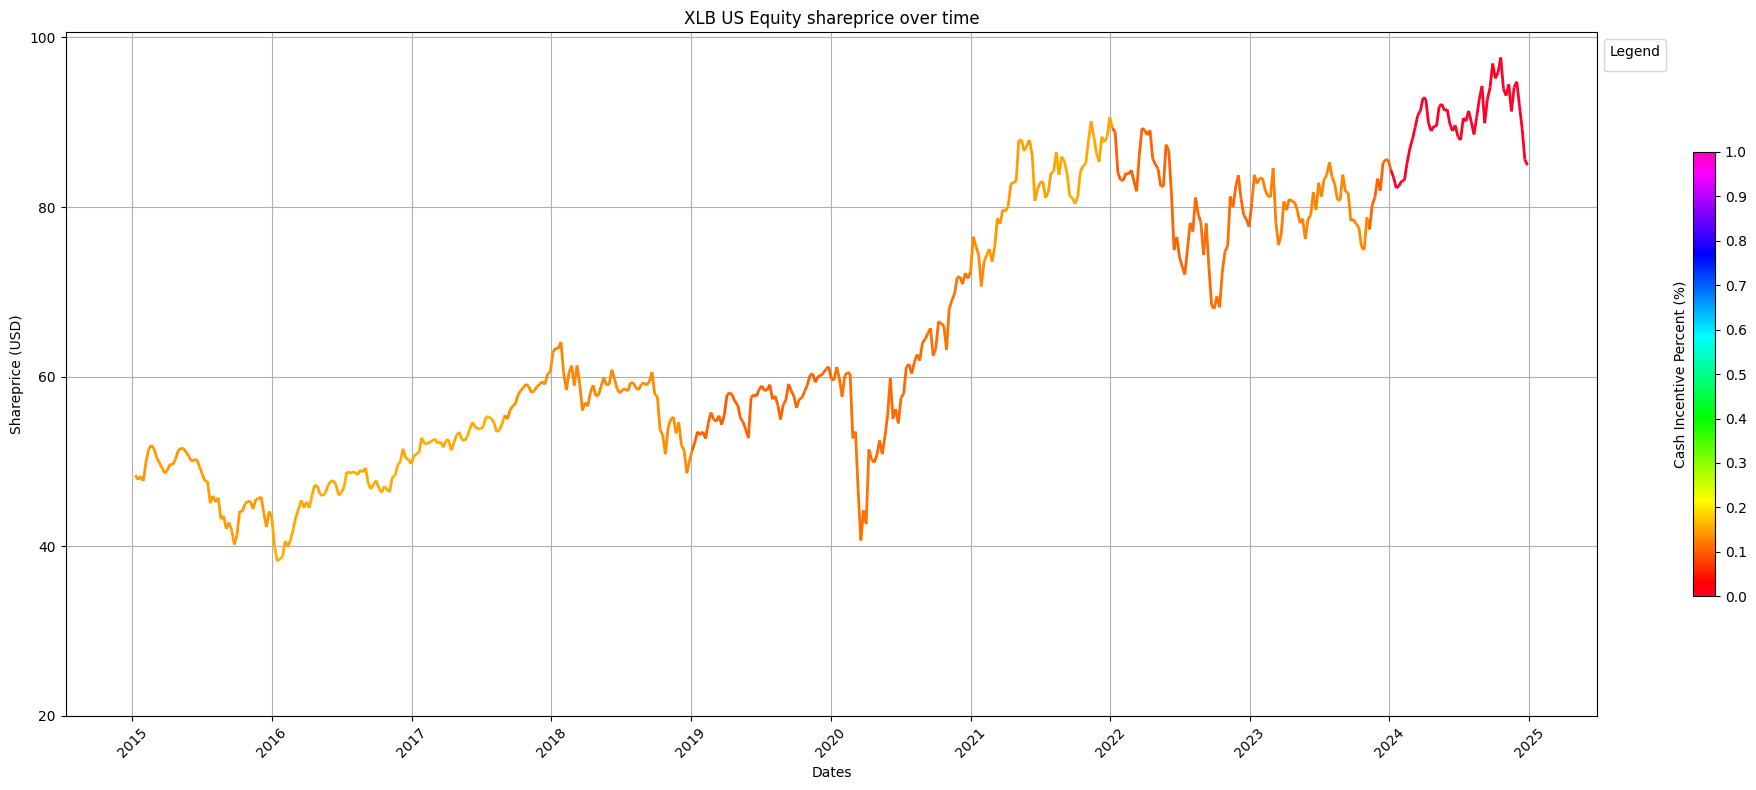

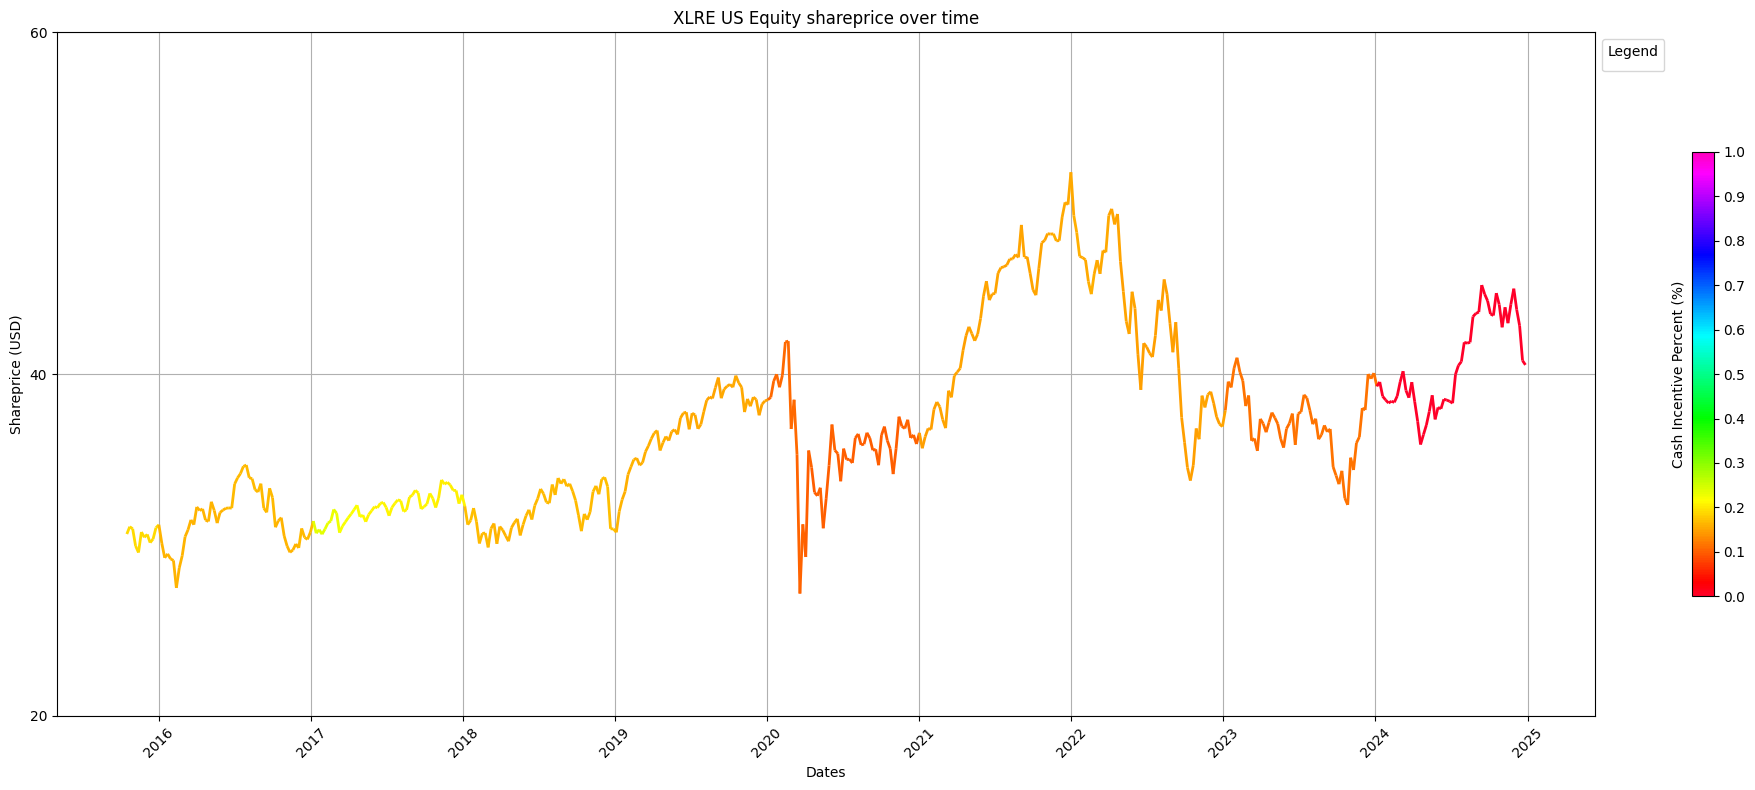

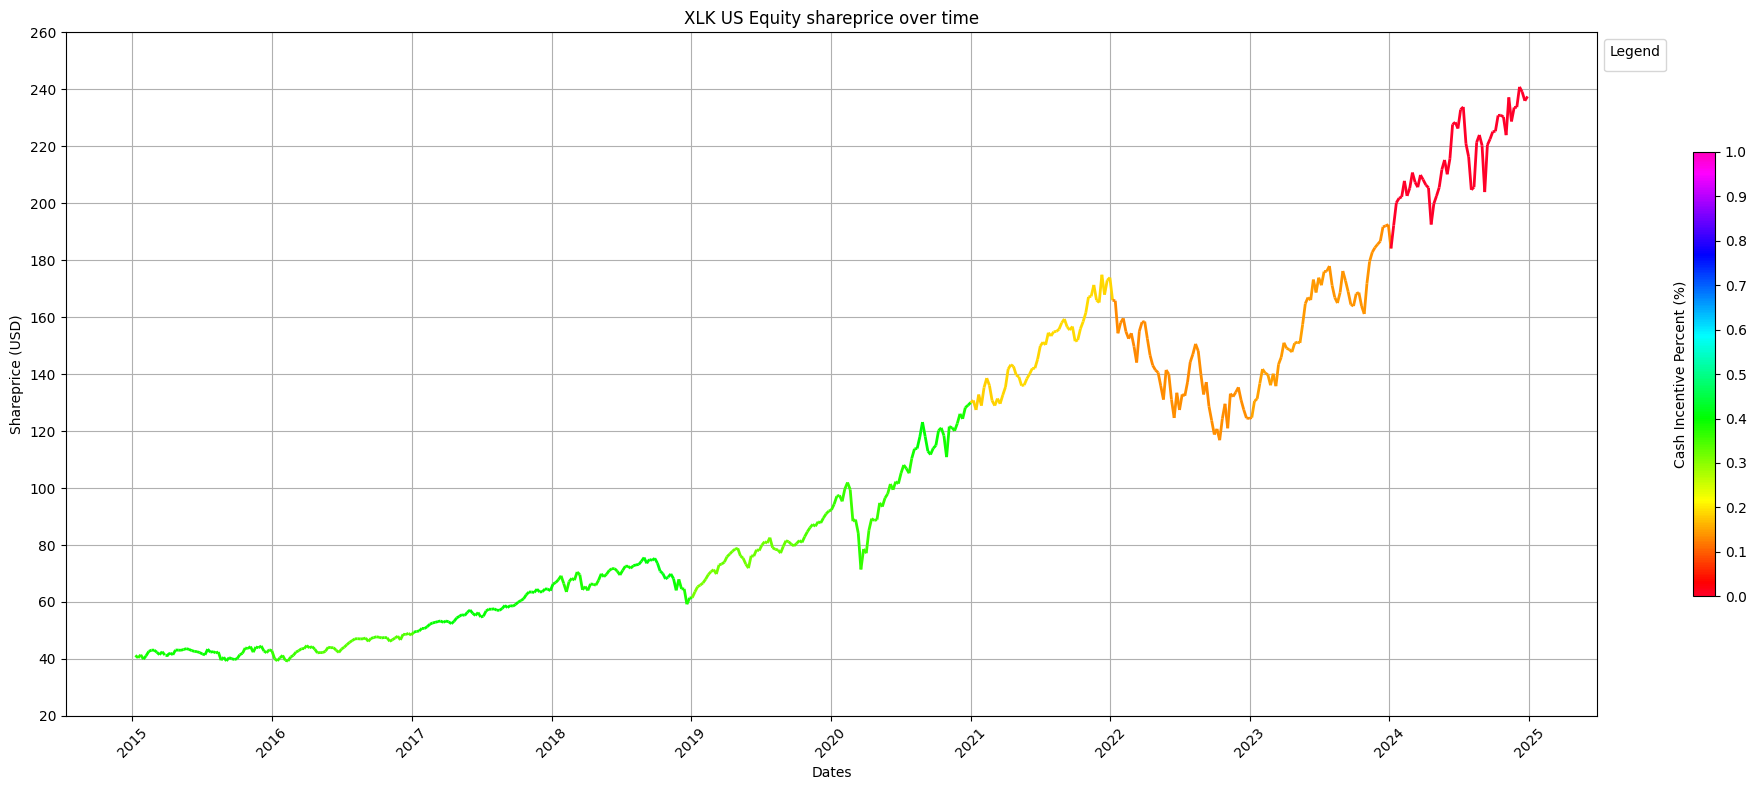

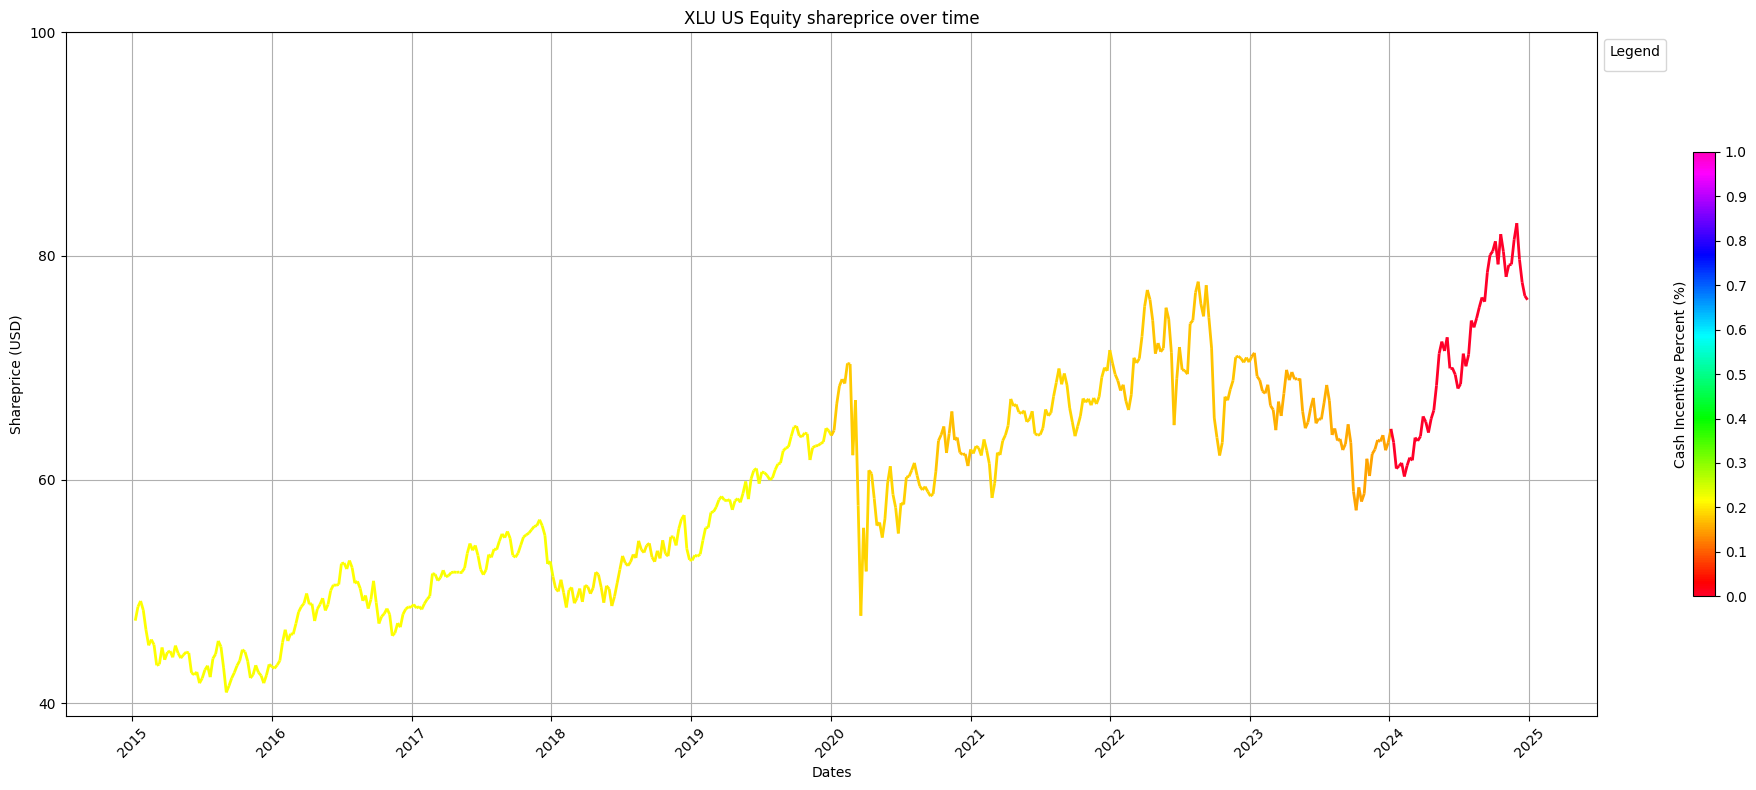

In [77]:
for i in Data_ETF["symbol"].unique():
   plot_returns(i)